# A (very) short primer on Bayesian vs. Frequentist regression

# LPO Quantitative Methods Colloquium | 11 April 2017
### Benjamin Skinner & Will Doyle

In [13]:
## libraries and jupyter-specific options
libs <- c('tidyverse','lme4','rstan','rstanarm','shinystan','tidyr')
suppressMessages(invisible(lapply(libs, require, character.only = TRUE)))
options(width = 120, warn = -1)

# Overview of Bayesian inference

![](https://imgs.xkcd.com/comics/frequentists_vs_bayesians.png)
![](https://imgs.xkcd.com/comics/seashell.png)

 ### Paper 

> Gill, Jeff and Christopher Witko (2013) "[Bayesian Analytical Methods: A Methodological Prescription for Public Administration](https://academic.oup.com/jpart/article-abstract/23/2/457/1003493/Bayesian-Analytical-Methods-A-Methodological?redirectedFrom=fulltext)." *Journal of Public Administration Research and Theory*, 23 (2), 457-494. doi: [10.1093/jopart/mus091](https://doi.org/10.1093/jopart/mus091)

# Methods to compute posterior distributions

## Analytic (closed-form solutions)

### EXAMPLE: Repeated binary trials (*i.e.,* coin flips)

**Likelihood**: [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution)
$$ p(X \mid \theta) = {n \choose k}\theta^k(1-\theta)^{n-k}\tag{$k$ successes of $n$ trials} $$

**Prior**: [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)
$$ p(\theta) = \frac{1}{Beta(\alpha,\beta)}\theta^{\alpha - 1}(1-\theta)^{\beta - 1} \tag{$\alpha$ successes, $\beta$ failures} $$

**Posterior**: [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)
\begin{align}
p(\theta \mid X) &= {n \choose k}\theta^k(1-\theta)^{n-k} \times 
\frac{1}{Beta(\alpha,\beta)}\theta^{\alpha - 1}(1-\theta)^{\beta - 1} \tag{multiplied together}\\
\\
p(\theta \mid X) &\propto \theta^k(1-\theta)^{n-k} \times \theta^{\alpha - 1}(1-\theta)^{\beta - 1} \tag{drop constant terms, now proportional}\\
\\
p(\theta \mid X) &\propto \theta^{k + \alpha - 1}(1-\theta)^{n - k + \beta - 1} \tag{algebra!} \\
p(\theta \mid X) &\sim Beta(\alpha + k, \beta + n - k)
\end{align}

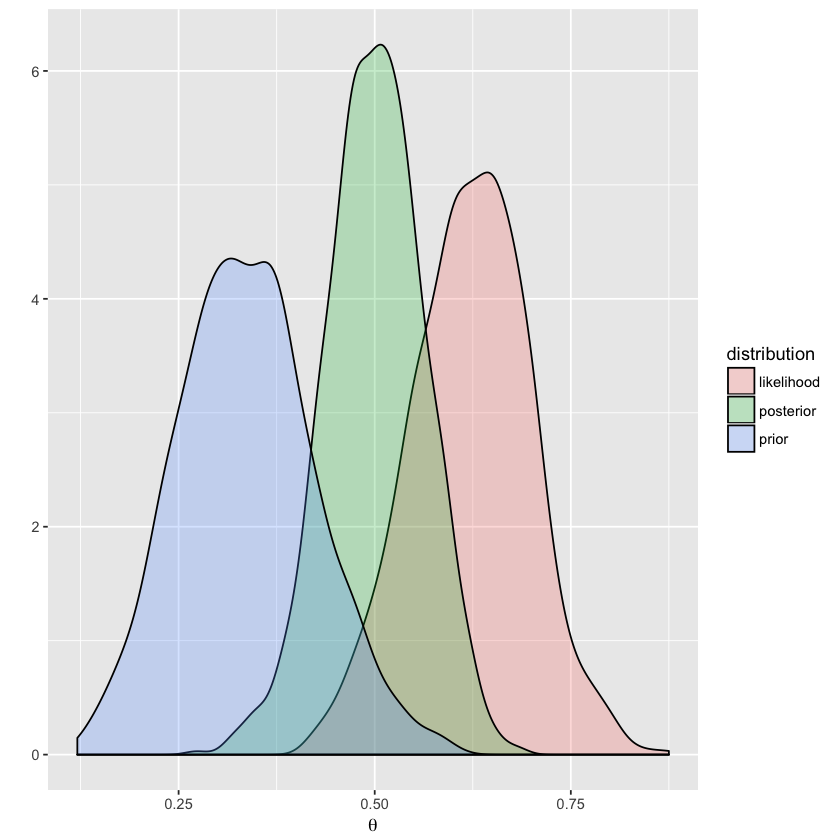

In [14]:
## data (k = success; n = total trials)
x <- c(rep(1, 25), rep(0, 15))
k <- sum(x == 1)
n <- length(x)

## prior hyperparameters (a = success; b = failure)
a <- 10
b <- 20

## prior, likelihood, posterior: random draws
prior <- rbeta(1000, a, b)
likelihood <- rbinom(1000, n, k/n)
posterior <- rbeta(1000, a + k, b + n - k)

## put into data frame
analytic_bayes <- data.frame(prior = prior,
                    likelihood = likelihood / n, # want to compare theta, not actual draws
                    posterior = posterior) %>%
          gather(distribution, theta) %>%
          mutate(distribution = as.factor(distribution))

## plot
ggplot(analytic_bayes, aes(x = theta, fill = distribution)) + 
    geom_density(alpha = 0.25) +
    ylab('') +
    xlab(expression(theta))

### Analytic computation: pros and cons

**Pros**
1. Sometimes very easy to compute
2. Gives the clearest description of the posterior

**Cons**
1. Algebra + [knowledge of conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior)
2. Never available for interesting problems

## Markov Chain Monte Carlo (MCMC) Sampling

For most interesting problems, there isn't an analytic or closed form solution to the posterior distribution. Or it's a pain to compute. In these situations one can try to directly sample from the posterior distribution through the choice of some computational method and then rely on [Markov Chain Monte Carlo theory (MCMC)](http://www.mcmchandbook.net/HandbookChapter1.pdf) when making inferences. MCMC theory is complex, so we won't delve into it today. Suffice to say that it is what permits us to feel confident that conditional on meeting certain conditions, our samples represent a good/useful approximation of the true posterior.

### MCMC alogorithms (50k foot view of the procedure)
1. Decide upon method for choosing parameters ($\beta$ in a regression, for example)
2. Have rule for deciding whether parameters are good

#### Procedure

To produce $S$ samples from the posterior:
    
    1. Initialize all unknowns (e.g., regression coefficients) with some starting values  
    while (s < S):
        2. Choose new parameter
        3. Implement decision rule:
            1. Keep new parameter if rule says good
            2. Drop new parameter if rule says bad and keep old one
        4. Store value based on decision

As always, the devil is in the details. Specifically:  
1. *What's a good way to generate new values for parameters?*  
2. *What's a good rule for deciding whether to keep the new parameter?*

There are many, many methods for accomplishing this task. The following three are the most common. We won't go into the math behind, but those who are interested can check out the first chapter of the [MCMC Handbook](http://www.mcmchandbook.net/HandbookChapter1.pdf).

### Gibbs Sampler

The [Gibbs Sampler](https://en.wikipedia.org/wiki/Gibbs_sampling) is a compromise between a fully analytic and a fully computational approach. Think of a posterior with multiple unknowns, for example, a normal linear regression where $\beta$ and the regression variance term, $\sigma^2$ are unknown. The full joint posterior, $ p(\beta, \sigma^2 \mid X) $, may be intractable or difficult to solve. On the other hand, the marginal posterior distributions of the terms, $ p(\beta \mid X, \sigma^2) $ and $ p(\sigma^2 \mid X, \beta) $, may be more tractable.

The Gibbs sampling algorithm therefore uses a bit of algebra to rearrange the full posterior into a set of marginal posteriors, one for each unknown or group of unknowns. The algorithm then follows this procedure:

```
1. initialize all parameters
for (s < S):
    2. update first unknown
    3. update second unknown
    ...
    4. update last unknown
    5. store all updates
```

Because the marginal posteriors are solveable, all new parameter choices are selected when updating.

### Metropolis-Hastings

The [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm) sampler doesn't try to compute marginal posteriors. Instead, it selects new parameters from a proportional candidate distribution, compares a function of these parameters to a function of the old parameters, and accepts/rejects based on a probabilistic decision rule. The steps for MH in a regression framework are:

```
1. initialize all parameters
for (s < S):
    2. choose new parameters from candidate distribution
    3. compute the log likelihood (ll) of the data using these parameters
    4. compute ratio: ll_new / ll_old = alpha
    5. accept with probability: min(1, alpha)

```

The MH sampler will always accept new values that improve the fit (increase the log-likelihood). It won't necessarily reject those that reduce the log-likelihood, however. If they are close ($\alpha = .98$), they are quite likely to be accepted. On rare occasions, they will be accepted even when they are not that great. This feature allows the sampler to "jump around" and (hopefully) not become stuck in local maxima.

### Hamiltonian Monte Carlo

The Hamilton Monte Carlo sampler is the hot new sampler. It uses Hamiltonian mechanics to simulate a particle moving around the posterior parameter space. The particle is given both potential and kinetic energy. Based on the gradient (shape) of the posterior, the particle is given direction. 

Imagine a hockey puck given a shove in a swimming pool. It will move around the pool, going up and down the sides. It may land in the shallow end quite often, but over time, it will more often end up in the deep end. Provided the algorithm can be tuned well (so the puck doesn't go flying outside of the pool), the HMC sampler can be very efficient at exploring the posterior parameter space.

Stan uses a variant of the HMC, its No-U-Turn Sampler (NUTS). Because the HMC particle can double back on itself, it's not quite as efficient as it could be (imagine shoving the hockey puck and after moving all over the pool, it landed two inches from your hand). NUTS uses some additional coding to make sure that the HMC doesn't double back: no U turns!

## Enough words...let's see them in action!

[Visualizations of various MCMC algorithms](http://chi-feng.github.io/mcmc-demo/)

## Coding examples

## Data

Data come from the Kindergarten year of the Tennessee STAR class reduction experiment. The data can be downloaded from the [Harvard Dataverse archive](https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/10766). The script to make the reduced data set used in these examples, `clean_data.R`, is in the repo.

In [15]:
## read data
df <- readr::read_csv('tn_star_k.csv')

Parsed with column specification:
cols(
  .default = col_integer(),
  math_std = col_double(),
  read_std = col_double()
)
See spec(...) for full column specifications.


## Codebook

|Variable|Description|
|:--|:--|
|studnid | Unique student ID|
|female| == 1 if student is female|
|black| == 1 if student is Black|
|asian| == 1 if student is Asian|
|hispc| == 1 if student is Hispanic|
|natam| == 1 if student is Native American|
|orace| == 1 if student is another Race/ethnicity|
|t\_smc| == 1 if treatment is a small class|
|t\_rgc| == 1 if treatment is a regular class|
|t\_rga| == 1 if treatment is a regular class with a teacher's aide|
|incit| == 1 if student lives in inner city area|
|subur| == 1 if student lives in suburban area|
|urban| == 1 if student lives in urban area|
|rural| == 1 if student lives in rural area|
|frpr| == 1 if student receives free or reduced price lunch|
|spced| == 1 if student receives special education services|
|math| math test score|
|read| reading test score|
|math\_std| standardized math test score|
|read\_std| standardized reading test score|

# Single Level Models

** Formula **
$$ y_i = \beta_0 + \beta_{smc} \cdot T_i^{small\,class} + \beta_{aid} \cdot T_i^{aide} + X_i \beta_k + \varepsilon_i $$

## Frequentist

In [16]:
## frequentist linear model
freq_lm <- lm(math_std ~ t_smc + t_rga + female + black + asian
              + hispc + natam + orace + incit + subur + urban
              + frpl + spced,
              data = df)

In [17]:
## print
summary(freq_lm)


Call:
lm(formula = math_std ~ t_smc + t_rga + female + black + asian + 
    hispc + natam + orace + incit + subur + urban + frpl + spced, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2127 -0.6473 -0.1086  0.5723  3.1936 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.046414   0.034696   1.338 0.181054    
t_smc        0.217763   0.036788   5.919 3.49e-09 ***
t_rga       -0.001466   0.035595  -0.041 0.967153    
female       0.156034   0.029503   5.289 1.29e-07 ***
black       -0.200674   0.052536  -3.820 0.000136 ***
asian       -0.022224   0.289836  -0.077 0.938883    
hispc       -0.559807   0.479189  -1.168 0.242776    
natam       -1.454078   0.957655  -1.518 0.128995    
orace       -0.259240   0.391374  -0.662 0.507760    
incit        0.033626   0.060235   0.558 0.576709    
subur        0.217908   0.042198   5.164 2.53e-07 ***
urban       -0.031444   0.055058  -0.571 0.567950    
frpl        -0.339655   0.034649  

## Bayesian

In [18]:
## show Stan model
writeLines(readLines('normal.stan'))

// normal.stan
data {
  int<lower=0> N;
  int<lower=0> K;
  matrix[N,K] x;
  vector[N] y;
}
parameters {
  real alpha;
  vector[K] beta;
  real<lower=0> sigma;
}
model {
  // regression parameter and error prior
  beta ~ normal(0,10);
  sigma ~ cauchy(0,10);

  // likelihood
  y ~ normal(alpha + x * beta, sigma);
}


In [19]:
## compile Stan model
norm_mod <- stan_model(file = 'normal.stan')

In [20]:
## set up Stan data in list
y <- df$math_std
x <- df %>%
    select(t_smc, t_rga, female, black, asian,
           hispc, natam, orace, incit, subur, urban,
           frpl, spced) %>%
    as.matrix(.)
N <- nrow(x)
K <- ncol(x)

stan_df <- list('y' = y, 'x' = x, 'N' = N, 'K' = K)

In [21]:
## Bayesian linear model using rstan
bayes_lm_1 <- sampling(norm_mod,
                       data = stan_df,
                       iter = 1000,
                       chains = 3,
                       cores = 3,
                       pars = c('alpha','beta','sigma','lp__'))

In [22]:
## print
print(bayes_lm_1)

Inference for Stan model: normal.
3 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1500.

             mean se_mean   sd     2.5%      25%      50%      75%    97.5% n_eff Rhat
alpha        0.05    0.00 0.04    -0.02     0.02     0.05     0.07     0.12  1500    1
beta[1]      0.22    0.00 0.04     0.14     0.19     0.22     0.24     0.29  1500    1
beta[2]      0.00    0.00 0.04    -0.07    -0.02     0.00     0.02     0.07  1500    1
beta[3]      0.16    0.00 0.03     0.10     0.13     0.16     0.18     0.21  1500    1
beta[4]     -0.20    0.00 0.05    -0.30    -0.23    -0.20    -0.16    -0.10  1447    1
beta[5]     -0.03    0.01 0.28    -0.58    -0.21    -0.03     0.15     0.51  1500    1
beta[6]     -0.57    0.01 0.49    -1.54    -0.90    -0.58    -0.24     0.39  1500    1
beta[7]     -1.46    0.02 0.94    -3.35    -2.10    -1.46    -0.80     0.28  1500    1
beta[8]     -0.26    0.01 0.39    -0.99    -0.55    -0.26     0.01 

In [23]:
## Bayesian linear model using rstanarm
bayes_lm_2 <- stan_glm(math_std ~ t_smc + t_rga + female + black + asian
                       + hispc + natam + orace + incit + subur + urban
                       + frpl + spced,
                       data = df,
                       family = gaussian(link = 'identity'),
                       chains = 3,
                       cores = 3,
                       iter = 1000)

In [24]:
## print
summary(bayes_lm_2, digits = 2)

stan_glm(formula = math_std ~ t_smc + t_rga + female + black + 
    asian + hispc + natam + orace + incit + subur + urban + frpl + 
    spced, family = gaussian(link = "identity"), data = df, chains = 3, 
    cores = 3, iter = 1000)

Family: gaussian (identity)
Algorithm: sampling
Posterior sample size: 1500
Observations: 4222

Estimates:
                mean     sd       2.5%     25%      50%      75%      97.5% 
(Intercept)       0.05     0.04    -0.03     0.02     0.05     0.07     0.12
t_smc             0.22     0.04     0.15     0.19     0.22     0.24     0.29
t_rga             0.00     0.04    -0.07    -0.03     0.00     0.02     0.07
female            0.16     0.03     0.10     0.13     0.16     0.18     0.22
black            -0.20     0.05    -0.30    -0.23    -0.20    -0.17    -0.10
asian            -0.03     0.29    -0.62    -0.22    -0.03     0.16     0.54
hispc            -0.57     0.46    -1.49    -0.88    -0.57    -0.27     0.34
natam            -1.42     0.97    -3.26   

In [25]:
## check convergence
# launch_shinystan(bayes_lm_1, quiet = TRUE)

# Varying intercept models

** Formula **
\begin{align} 
y_i &= \beta_j + \beta_{smc} \cdot T_i^{small\,class} + \beta_{aid} \cdot T_i^{aide} + X_i \beta_k + \varepsilon_i \\
\beta_j &\sim Normal(\mu, \sigma_j)
\end{align}

## Frequentist

In [26]:
## varying intercept model
freq_vi <- lmer(math_std ~ -1 + t_smc + t_rga + female + black + asian
                + hispc + natam + orace + incit + subur + urban
                + frpl + spced + (1 | school),
                data = df)
summary(freq_vi)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
	 vcov(obj)	 if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: math_std ~ -1 + t_smc + t_rga + female + black + asian + hispc +  
    natam + orace + incit + subur + urban + frpl + spced + (1 |      school)
   Data: df

REML criterion at convergence: 10902.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1310 -0.6836 -0.0655  0.5905  3.9970 

Random effects:
 Groups   Name        Variance Std.Dev.
 school   (Intercept) 0.1928   0.4391  
 Residual             0.7353   0.8575  
Number of obs: 4222, groups:  school, 73

Fixed effects:
       Estimate Std. Error t value
t_smc   0.25389    0.03308   7.675
t_rga   0.04539    0.03212   1.413
female  0.12610    0.02630   4.795
black  -0.31996    0.05917  -5.407
asian  -0.01811    0.26312  -0.069
hispc  -0.29833    0.43355  -0.688
natam  -0.43563    0.86284  -0.505
orace  -0.22393    0.35490  -0.631
incit   0.15434    0.13289   1.161
subur   0.27890    0.11861   2.352
urban   0.04318    0.18751   0.230
frpl   -0.37563    0.03201 -11.735
s

## Bayesian

In [27]:
## show Stan model
writeLines(readLines('vi_normal.stan'))

// vi_normal.stan
data {
  int<lower=1> N;
  int<lower=1> J;
  int<lower=1> K;
  matrix[N,K] x;
  vector[N] y;
  int school[N];
}
parameters {
  real alpha_mu;
  vector[J] alpha;
  vector[K] beta;
  real<lower=0> sigma;
  real<lower=0> alpha_sigma;
}
model {
  // hyper priors
  alpha_mu ~ normal(0,1);
  alpha_sigma ~ cauchy(0,2.5);

  // random intercept prior
  alpha ~ normal(alpha_mu, alpha_sigma);

  // regression parameter and error prior
  beta ~ normal(0,10);
  sigma ~ cauchy(0,10);

  // likelihood
  y ~ normal(alpha[school] + x * beta, sigma);
}


In [28]:
## compile Stan model
vi_norm_mod <- stan_model(file = 'vi_normal.stan')

In [29]:
## add information for school-level varying intercepts
school <- df$school
J <- length(unique(school))

stan_df <- list('y' = y, 'x' = x, 'N' = N, 'K' = K, 'J' = J, 'school' = school)

In [30]:
## Bayesian varying intercept model using rstan
bayes_vi_1 <- sampling(vi_norm_mod,
                       data = stan_df,
                       iter = 2000,
                       chains = 3,
                       cores = 3,
                       pars = c('alpha_mu','alpha','beta',
                                'alpha_sigma','sigma','lp__'))

In [31]:
## print results
print(bayes_vi_1)

Inference for Stan model: vi_normal.
3 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=3000.

                mean se_mean   sd     2.5%      25%      50%      75%    97.5% n_eff Rhat
alpha_mu        0.04    0.00 0.08    -0.12    -0.01     0.04     0.10     0.20   542 1.01
alpha[1]       -0.43    0.01 0.23    -0.90    -0.59    -0.43    -0.28     0.02   772 1.00
alpha[2]       -0.17    0.00 0.13    -0.43    -0.26    -0.17    -0.08     0.09  3000 1.00
alpha[3]       -0.21    0.00 0.13    -0.46    -0.29    -0.21    -0.12     0.04  3000 1.00
alpha[4]       -0.61    0.01 0.19    -1.01    -0.73    -0.61    -0.47    -0.23   720 1.00
alpha[5]       -0.52    0.00 0.12    -0.76    -0.60    -0.52    -0.43    -0.28  3000 1.00
alpha[6]       -0.38    0.01 0.18    -0.74    -0.49    -0.38    -0.26    -0.04   672 1.01
alpha[7]        0.62    0.00 0.10     0.42     0.55     0.62     0.69     0.83  3000 1.00
alpha[8]       -0.25    0.00 0.13  

In [32]:
## Bayesian varying intercept model using rstanarm
bayes_vi_2 <- stan_glmer(math_std ~ -1 + t_smc + t_rga + female + black + asian
                         + hispc + natam + orace + incit + subur + urban
                         + frpl + spced + (1 | school),
                         data = df,
                         family = gaussian(link = 'identity'),
                         chains = 3,
                         cores = 3,
                         iter = 2000)

In [33]:
## print results
summary(bayes_vi_2, digits = 2)

stan_glmer(formula = math_std ~ -1 + t_smc + t_rga + female + 
    black + asian + hispc + natam + orace + incit + subur + urban + 
    frpl + spced + (1 | school), data = df, family = gaussian(link = "identity"), 
    chains = 3, cores = 3, iter = 2000)

Family: gaussian (identity)
Algorithm: sampling
Posterior sample size: 3000
Observations: 4222
Groups: school 73

Estimates:
                                        mean     sd       2.5%     25%      50%      75%      97.5% 
t_smc                                     0.25     0.03     0.19     0.23     0.25     0.28     0.32
t_rga                                     0.05     0.03    -0.02     0.03     0.05     0.07     0.11
female                                    0.13     0.03     0.07     0.11     0.13     0.14     0.18
black                                    -0.32     0.06    -0.44    -0.36    -0.32    -0.28    -0.21
asian                                    -0.03     0.26    -0.53    -0.20    -0.02     0.14     0.49
hispc        

In [34]:
## check convergence
# launch_shinystan(bayes_vi_1, quiet = TRUE)